In [1]:
import sys
import os
#homedir = os.path.dirname(os.path.abspath(__file__))
homedir = os.path.abspath('')
sys.path.append(os.path.dirname(os.path.dirname(homedir)))
#print(os.path.dirname(os.path.dirname(homedir)))
#!pip install torch_lr_finder

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from torch_lr_finder import LRFinder


SEED = 1
use_cuda = torch.cuda.is_available()
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
from EVA8_assignments.models.model9_ultimus import get_ultimus
from EVA8_assignments.models.utils.train_loop import train, test, get_schedulder, sgd_optim
from EVA8_assignments.models.utils.data_utils import get_augmented_cifar10_dataset, default_train_transforms, default_test_transforms, assn8_train_transforms, assn8_test_transforms

In [5]:
ultimus = get_ultimus()
ultimus = ultimus.to(device)

In [6]:
model_copy = copy.deepcopy(ultimus)
model_copy.to(device)

BasicTransformer(
  (conv_blk): Sequential(
    (0): conv_relu_bn_dropout_blk(
      (conv): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (1): conv_relu_bn_dropout_blk(
      (conv): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
    )
    (2): conv_relu_bn_dropout_blk(
      (conv): Sequential(
        (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (gap1): AdaptiveAvgPo

In [7]:
#These dataloaders are just for OCP LR finding. We don't use any augmentations even for train dataloader
cifar10_trainloader_ocp, cifar10_testloader_ocp = get_augmented_cifar10_dataset("/home/raghuc/work/data/", train_tfms=assn8_test_transforms, test_tfms=assn8_test_transforms, batch_sz=512, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.26E-02


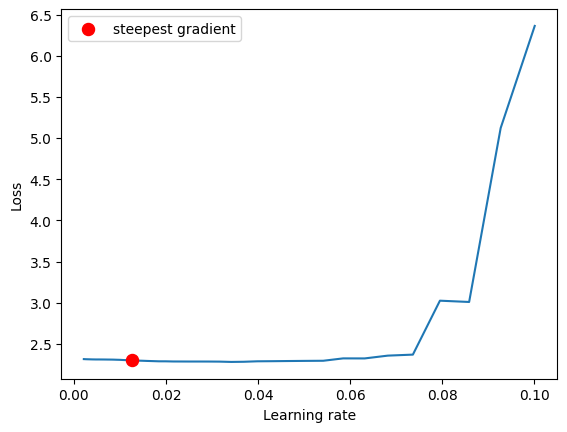

(<AxesSubplot: xlabel='Learning rate', ylabel='Loss'>, 0.01259921049894873)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer_ocp = optim.Adam(model_copy.parameters(), lr=0.001)
lr_finder = LRFinder(model_copy, optimizer_ocp, criterion, device=device)
lr_finder.range_test(cifar10_trainloader_ocp, end_lr=2, num_iter=100)
lr_finder.plot(log_lr=False)

In [9]:
min_loss = min(lr_finder.history['loss'])
lr_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR: ", lr_rate)

Max LR:  0.034183137124932435


In [10]:
cifar10_trainloader, cifar10_testloader = get_augmented_cifar10_dataset("/home/raghuc/work/data/", train_tfms=assn8_test_transforms, test_tfms=assn8_test_transforms, batch_sz=512)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
optimizer = torch.optim.Adam(ultimus.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_rate, steps_per_epoch=len(cifar10_trainloader), epochs=24, pct_start=0.2, div_factor=10, three_phase=False, final_div_factor=20,anneal_strategy='linear')

In [12]:
EPOCHS = 24

train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(ultimus, device, cifar10_trainloader, optimizer, epoch, train_losses, train_acc)
    scheduler.step()
    test(ultimus, device, cifar10_testloader, test_losses, test_acc)

EPOCH: 0


Loss=2.072941780090332 Batch_id=97 Accuracy=15.82: 100%|████████████████████████████| 98/98 [00:04<00:00, 23.91it/s]



Test set: Average loss: 1.9607, Accuracy: 1937/10000 (19.37%)

EPOCH: 1


Loss=1.9662846326828003 Batch_id=97 Accuracy=18.79: 100%|███████████████████████████| 98/98 [00:04<00:00, 24.39it/s]



Test set: Average loss: 1.9128, Accuracy: 2230/10000 (22.30%)

EPOCH: 2


Loss=1.9632104635238647 Batch_id=97 Accuracy=19.62: 100%|███████████████████████████| 98/98 [00:04<00:00, 24.12it/s]



Test set: Average loss: 1.8857, Accuracy: 2334/10000 (23.34%)

EPOCH: 3


Loss=1.9240392446517944 Batch_id=97 Accuracy=20.96: 100%|███████████████████████████| 98/98 [00:04<00:00, 24.07it/s]



Test set: Average loss: 1.8607, Accuracy: 2470/10000 (24.70%)

EPOCH: 4


Loss=1.9644747972488403 Batch_id=97 Accuracy=22.70: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.66it/s]



Test set: Average loss: 1.8664, Accuracy: 2665/10000 (26.65%)

EPOCH: 5


Loss=1.8339933156967163 Batch_id=97 Accuracy=25.51: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.91it/s]



Test set: Average loss: 1.7040, Accuracy: 2931/10000 (29.31%)

EPOCH: 6


Loss=1.7753721475601196 Batch_id=97 Accuracy=29.47: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.80it/s]



Test set: Average loss: 1.7606, Accuracy: 3079/10000 (30.79%)

EPOCH: 7


Loss=1.8148009777069092 Batch_id=97 Accuracy=30.67: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.81it/s]



Test set: Average loss: 1.6596, Accuracy: 3551/10000 (35.51%)

EPOCH: 8


Loss=1.8471826314926147 Batch_id=97 Accuracy=32.22: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.87it/s]



Test set: Average loss: 1.6965, Accuracy: 3639/10000 (36.39%)

EPOCH: 9


Loss=1.7217676639556885 Batch_id=97 Accuracy=33.03: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.92it/s]



Test set: Average loss: 1.6905, Accuracy: 3496/10000 (34.96%)

EPOCH: 10


Loss=1.7122431993484497 Batch_id=97 Accuracy=33.80: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.58it/s]



Test set: Average loss: 1.5528, Accuracy: 3993/10000 (39.93%)

EPOCH: 11


Loss=1.806174874305725 Batch_id=97 Accuracy=34.10: 100%|████████████████████████████| 98/98 [00:04<00:00, 23.90it/s]



Test set: Average loss: 1.5382, Accuracy: 3902/10000 (39.02%)

EPOCH: 12


Loss=1.7049994468688965 Batch_id=97 Accuracy=35.11: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.86it/s]



Test set: Average loss: 1.5421, Accuracy: 3980/10000 (39.80%)

EPOCH: 13


Loss=1.7059041261672974 Batch_id=97 Accuracy=34.77: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.84it/s]



Test set: Average loss: 1.5399, Accuracy: 4003/10000 (40.03%)

EPOCH: 14


Loss=1.659477949142456 Batch_id=97 Accuracy=35.83: 100%|████████████████████████████| 98/98 [00:04<00:00, 23.65it/s]



Test set: Average loss: 1.5628, Accuracy: 3961/10000 (39.61%)

EPOCH: 15


Loss=1.611737608909607 Batch_id=97 Accuracy=35.79: 100%|████████████████████████████| 98/98 [00:04<00:00, 23.44it/s]



Test set: Average loss: 1.5212, Accuracy: 4143/10000 (41.43%)

EPOCH: 16


Loss=1.6210078001022339 Batch_id=97 Accuracy=35.79: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.79it/s]



Test set: Average loss: 1.5499, Accuracy: 4119/10000 (41.19%)

EPOCH: 17


Loss=1.7146196365356445 Batch_id=97 Accuracy=36.46: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.82it/s]



Test set: Average loss: 1.5007, Accuracy: 4278/10000 (42.78%)

EPOCH: 18


Loss=1.7155570983886719 Batch_id=97 Accuracy=37.04: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.27it/s]



Test set: Average loss: 1.4733, Accuracy: 4283/10000 (42.83%)

EPOCH: 19


Loss=1.5766088962554932 Batch_id=97 Accuracy=37.09: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.46it/s]



Test set: Average loss: 1.5247, Accuracy: 4109/10000 (41.09%)

EPOCH: 20


Loss=1.613828420639038 Batch_id=97 Accuracy=37.91: 100%|████████████████████████████| 98/98 [00:04<00:00, 23.31it/s]



Test set: Average loss: 1.4777, Accuracy: 4353/10000 (43.53%)

EPOCH: 21


Loss=1.569653868675232 Batch_id=97 Accuracy=38.06: 100%|████████████████████████████| 98/98 [00:04<00:00, 23.60it/s]



Test set: Average loss: 1.5538, Accuracy: 4139/10000 (41.39%)

EPOCH: 22


Loss=1.5908366441726685 Batch_id=97 Accuracy=38.60: 100%|███████████████████████████| 98/98 [00:04<00:00, 23.30it/s]



Test set: Average loss: 1.4315, Accuracy: 4572/10000 (45.72%)

EPOCH: 23


Loss=1.645391583442688 Batch_id=97 Accuracy=39.23: 100%|████████████████████████████| 98/98 [00:04<00:00, 23.44it/s]



Test set: Average loss: 1.4305, Accuracy: 4683/10000 (46.83%)



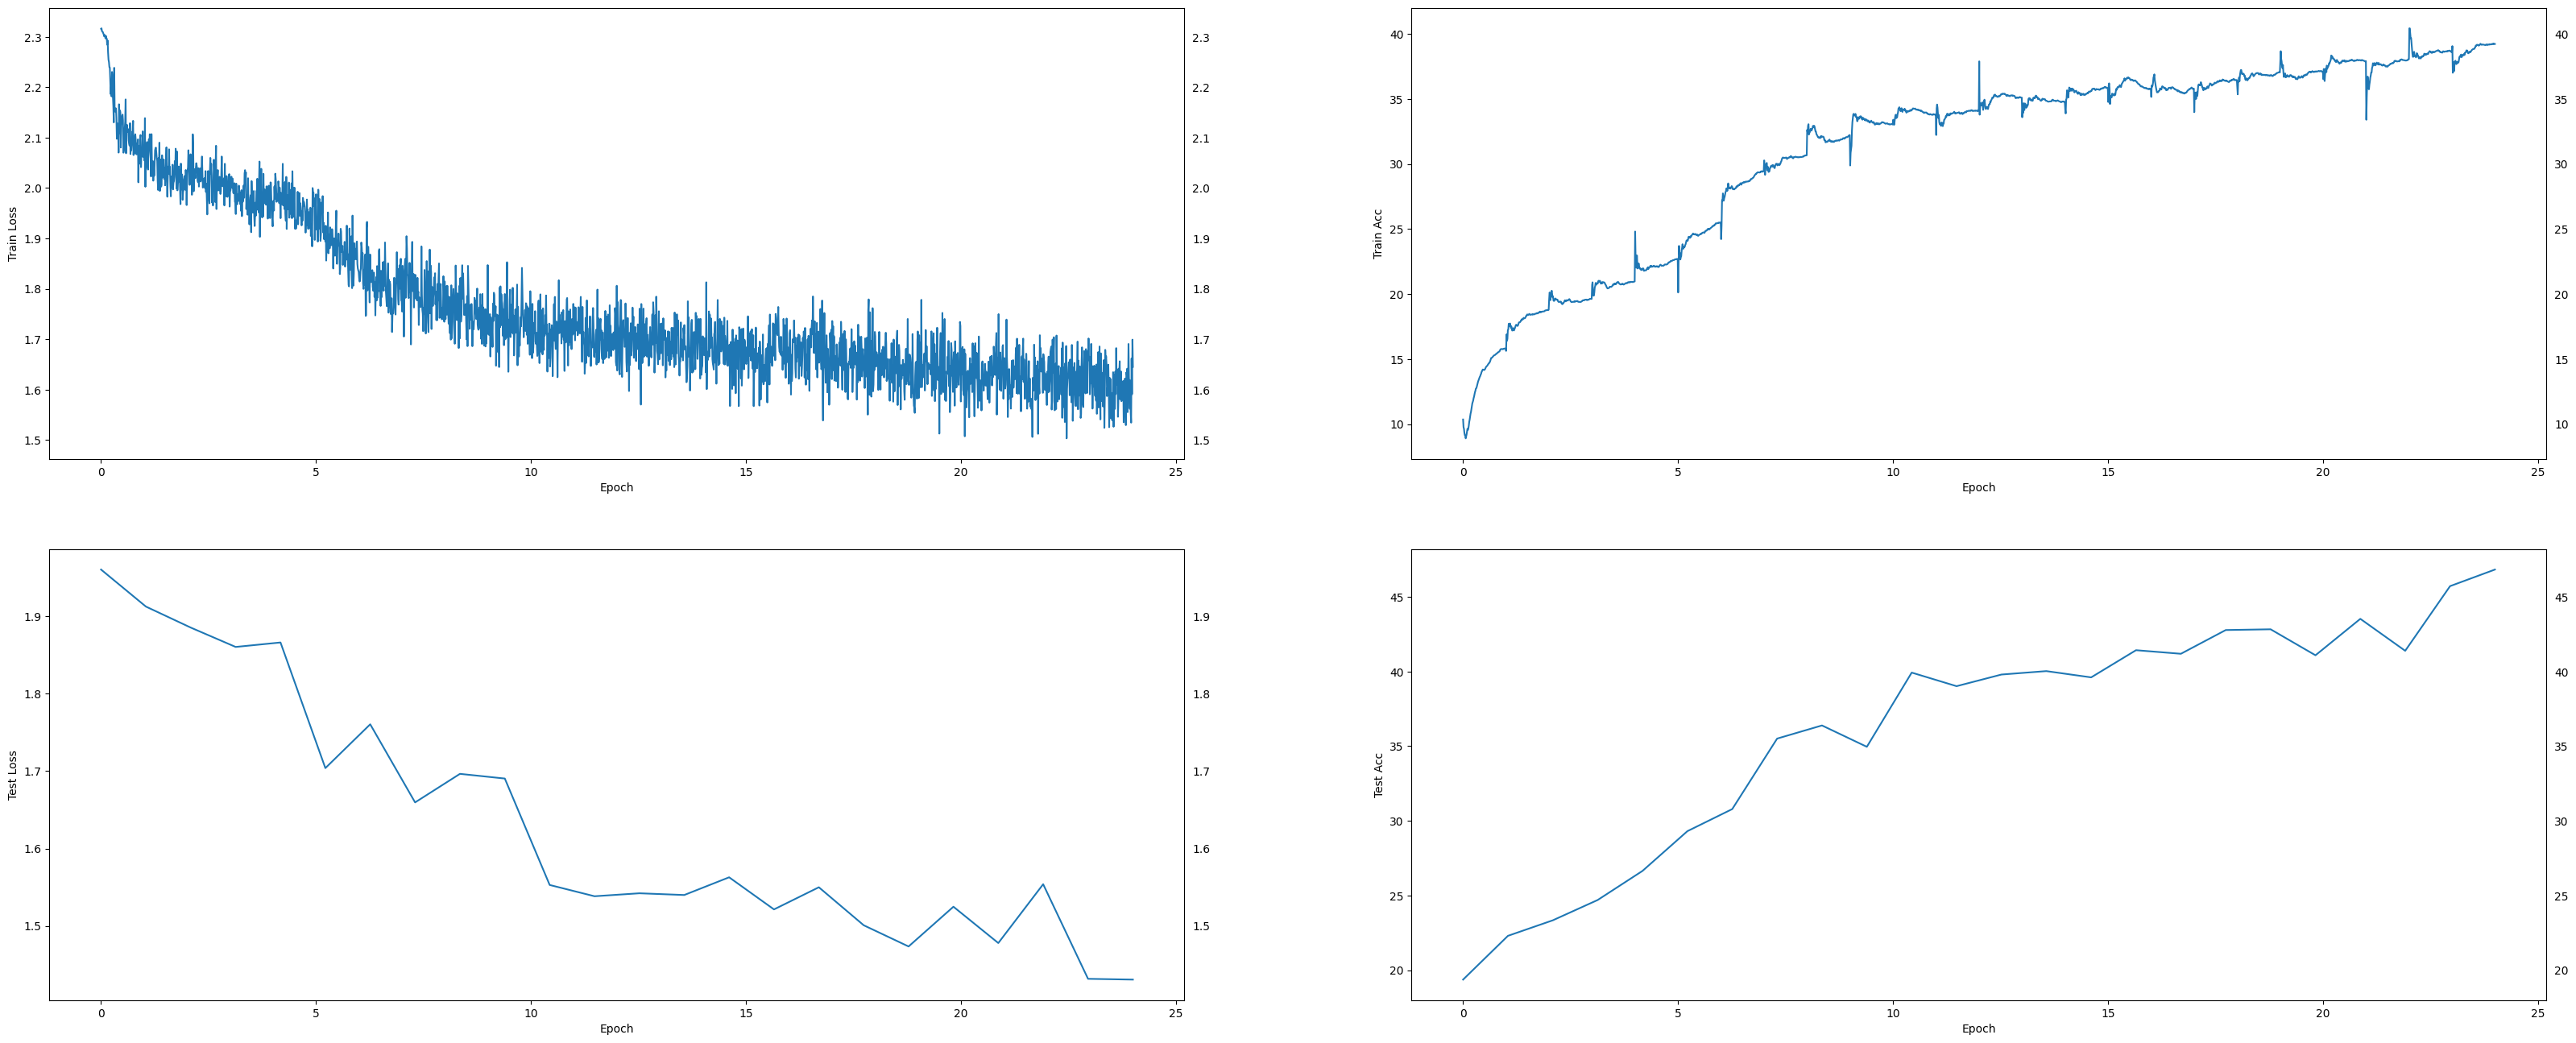

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 2)
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Train Loss")
ax[0][0].plot(np.linspace(0, EPOCHS, len(train_losses)), [i.detach().cpu().numpy() for i in train_losses])
ax[0][0].tick_params(axis="y", labelleft=True, labelright=True)

ax[0][1].set_xlabel("Epoch")
ax[0][1].set_ylabel("Train Acc")
ax[0][1].plot(np.linspace(0, EPOCHS, len(train_acc)), train_acc)
ax[0][1].tick_params(axis="y", labelleft=True, labelright=True)

ax[1][0].set_xlabel("Epoch")
ax[1][0].set_ylabel("Test Loss")
ax[1][0].plot(np.linspace(0, EPOCHS, len(test_losses)), test_losses)
ax[1][0].tick_params(axis="y", labelleft=True, labelright=True)

ax[1][1].set_xlabel("Epoch")
ax[1][1].set_ylabel("Test Acc")
ax[1][1].plot(np.linspace(0, EPOCHS, len(test_acc)), test_acc)
ax[1][1].tick_params(axis="y", labelleft=True, labelright=True)

fig.set_size_inches(40, 16)
plt.show()